# EXAMPLE OF FEDERATED LEARNING APPLICATION
## Safety, Privacy and Legal Aspects

In [1]:
import numpy as np
import tensorflow as tf
import keras

from keras.datasets import mnist
from tensorflow import keras
from keras import layers
from keras import models


In [2]:
# Read the MNIST data and process it. You can use reshape form numpy and to_categorical from 
# tensorflow.keras.utils

(X_train, y_train), (X_test, y_test) = mnist.load_data()

dimensión conjunto train: (60000, 28, 28)
dimensión conjunto test: (10000, 28, 28)


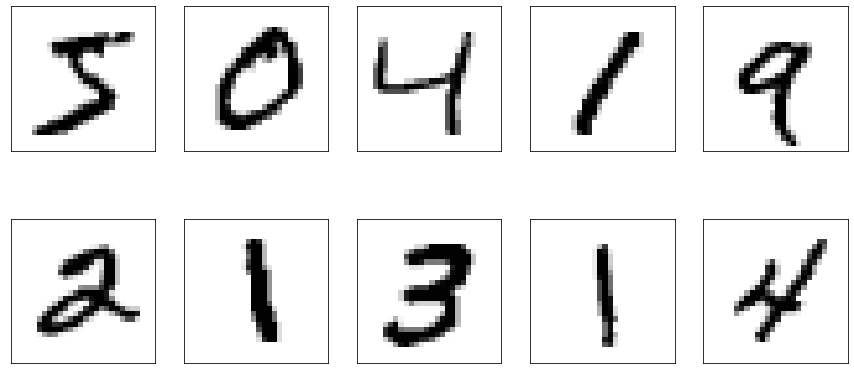

In [3]:
# To familiarize yourself with the data, you can display some of the images and their corresponding labels,
# and view their dimensions

print('dimensión conjunto train:',X_train.shape)
print('dimensión conjunto test:', X_test.shape)

#grafico algunos de los números
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 15))

for i in range(0,10):
    imagen = X_train[i,:,:]
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagen,cmap=plt.cm.binary)
    
plt.show()

In [4]:
train_images = X_train.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = X_test.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = keras.utils.to_categorical(
    y_train, num_classes=None, dtype='float32'
)
test_labels = keras.utils.to_categorical(
    y_test, num_classes=None, dtype='float32'
)


In [5]:
# Create 3 clients from the train data. You can do it as you prefer, either using slices 
# (e.g. client1_x = X_train[:len(X_train)//3]), creating a function that makes it automatic according
# to the number of clients desired (remember that two different customers cannot have data in common),
# or any other way you can think of.
client1_x = train_images[:len(X_train)//3]
client1_y = train_labels[:len(X_train)//3]

client2_x = train_images[len(X_train)//3:2*len(X_train)//3]
client2_y = train_labels[len(X_train)//3:2*len(X_train)//3]

client3_x = train_images[2*len(X_train)//3:len(X_train)]
client3_y = train_labels[2*len(X_train)//3:len(X_train)]

In [6]:
print(client1_x.shape)
print(client1_y.shape)

print(client2_x.shape)
print(client2_y.shape)

print(client3_x.shape)
print(client3_y.shape)

(20000, 28, 28, 1)
(20000, 10)
(20000, 28, 28, 1)
(20000, 10)
(20000, 28, 28, 1)
(20000, 10)


In [7]:
print(f'''Number of data for each customer: \n \t Client 1: {len(client1_x)}
     \t Client 2: {len(client2_x)} \n \t Client 3: {len(client3_x)}''')

Number of data for each customer: 
 	 Client 1: 20000
     	 Client 2: 20000 
 	 Client 3: 20000


In [8]:
# Check that the clients have been created correctly (that there is the same number of data in X_train as adding
# up all clients)
assert sum([len(client1_x), len(client2_x), len(client3_x)]) == len(X_train), 'Clients have not been created correctly'

In [9]:
# Create the model (neural network) with the layers you consider
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3) , activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64,(3,3) , activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64,(3,3) , activation='relu', input_shape=(28,28,1)))

model.add(layers.Flatten())

model.add(layers.Dense(units=64, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [10]:
opt = keras.optimizers.RMSprop(learning_rate=0.01)

model.compile(optimizer = opt,loss = "categorical_crossentropy", metrics=['accuracy'])
#history = model.fit(train_images,train_labels , epochs = 5,  batch_size = 64 )

In [11]:
def get_weights(model):
    weights = []
    # Get the initial weights:
    for layer in model.layers:
        weights.append(layer.get_weights()) # list of numpy arrays
    return weights

In [12]:
def set_init_weights(model,initial_weights):
    i=0
    for layer in model.layers:
        layer.set_weights(initial_weights[i])
        i+=1

In [13]:
def aggregate_weights(clients_len,weights_clients):
    N = sum(clients_len)

    avg_weights=initial_weights
    w=[clients_len[0]/N,clients_len[1]/N,clients_len[2]/N]

    for k in range(0,len(clients_len)):
        for i in range(0,len(weights_client1)):
            for j in range(0,len(weights_client1[i])):
                avg_weights[i][j] +=w[k]*weights_clients[k][i][j]
    return avg_weights

In [14]:
initial_weights = get_weights(model)
clients_len=[len(client1_x),len(client2_x),len(client3_x)]

In [15]:
history_client1=[]
history_client2=[]
history_client3=[]

In [16]:
 for i in range(0,3):
    # Train for the first client (remember to give the model the initial weights).
    print('Training client 1 for model {}...'.format(i+1))
    set_init_weights(model,initial_weights)  
    history_client1.append(model.fit(client1_x,client1_y, epochs = 5,  batch_size = 64, validation_split = 0.2))

    # Get the weights for client 1:
    weights_client1 = get_weights(model)


    # Train for the second client (remember to give the model the initial weights).
    print('Training client 2 for model {}...'.format(i+1))
    set_init_weights(model,initial_weights)  
    history_client2.append(model.fit(client2_x,client2_y, epochs = 5,  batch_size = 64, validation_split = 0.2))

    # Get the weights for client 2: 
    weights_client2 = get_weights(model)

    # Train for the third client (remember to set the initial weights for the model).
    print('Training client 3 for model {}...'.format(i+1))
    set_init_weights(model,initial_weights)  
    history_client3.append(model.fit(client3_x,client3_y, epochs = 5,  batch_size = 64, validation_split = 0.2))

    # Get the weights for client 3: 
    weights_client3 = get_weights(model)

    weights_clients=[weights_client1,weights_client2,weights_client3]

    # Aggregate the weights obtained with each client using an aggregation function that performs a weighted average:
    avg_weights = aggregate_weights(clients_len,weights_clients)
    # Save the resulting model (with the new weights), you will use it to train on the test set:
    set_init_weights(model,avg_weights) 


    model.save('model{}.h5'.format(i+1))

    initial_weights = avg_weights

    # Repeat the above process 2 more times (you can use a loop if you wish). Remember to update the weights
    # of the model as corresponds in each case 

Training client 1 for model 1...
Epoch 1/5
250/250 [==============================] - 7s 26ms/step - loss: 0.6542 - accuracy: 0.8366 - val_loss: 0.0896 - val_accuracy: 0.9710
Epoch 2/5
250/250 [==============================] - 6s 26ms/step - loss: 0.1235 - accuracy: 0.9646 - val_loss: 0.1052 - val_accuracy: 0.9660
Epoch 3/5
250/250 [==============================] - 6s 26ms/step - loss: 0.0895 - accuracy: 0.9750 - val_loss: 0.1366 - val_accuracy: 0.9682
Epoch 4/5
250/250 [==============================] - 6s 26ms/step - loss: 0.0782 - accuracy: 0.9781 - val_loss: 0.2110 - val_accuracy: 0.9485
Epoch 5/5
250/250 [==============================] - 7s 26ms/step - loss: 0.0787 - accuracy: 0.9799 - val_loss: 0.0841 - val_accuracy: 0.9778
Training client 2 for model 1...
Epoch 1/5
250/250 [==============================] - 6s 26ms/step - loss: 0.5093 - accuracy: 0.8569 - val_loss: 0.1413 - val_accuracy: 0.9565
Epoch 2/5
250/250 [==============================] - 6s 26ms/step - loss: 0.1165 -

**HINT**: some functions you need to know: set_weights, get_weights. Create an auxiliary function to aggregate the weights. This function will receive the number of data for each client (so that the average is weighted), and the weights for each of them. 

Let $N$ be the number of clients and $n_i$ the number of data for each of these, remember that this aggregation function is given by:

$$
\sum_{i=1}^{N} w_{i} \cdot weights\_client\_i
$$

$$
w_i = \frac{n_i}{\sum_{i=1}^{N}n_{i}} \hspace{0.5cm} \forall i \in \{1,...,N\}
$$

In [17]:
# Evaluate each saved model (you should have model1.h5, model2.h5 and model3.h5) with the test data,
# display and analyze the obtained results:

new_model1 = keras.models.load_model('model1.h5')
new_model2 = keras.models.load_model('model2.h5')
new_model3 = keras.models.load_model('model3.h5')

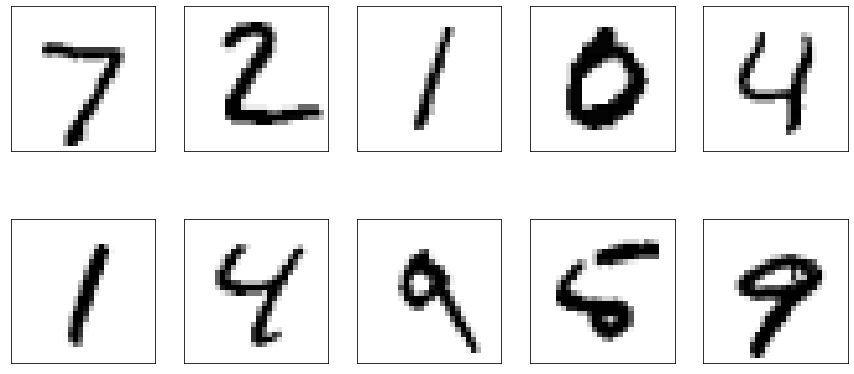

In [18]:
# testeo los modelos en algunos números en las imágenes de test para ver como funcionan:
plt.figure(figsize=(15, 15))

for i in range(0,10):
    imagen = X_test[i,:,:]
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagen,cmap=plt.cm.binary)
    
plt.show()

In [20]:
print('Los números predichos por el modelo 1 son:',[new_model1.predict_classes(test_images)[i] for i in range(0,10)])
print('Los números predichos por el modelo 2 son:',[new_model2.predict_classes(test_images)[i] for i in range(0,10)])
print('Los números predichos por el modelo 3 son:',[new_model3.predict_classes(test_images)[i] for i in range(0,10)])

Los números predichos por el modelo 1 son: [1, 1, 1, 0, 1, 1, 8, 1, 8, 8]
Los números predichos por el modelo 2 son: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]
Los números predichos por el modelo 3 son: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


In [21]:
#Ahora calculo el accuracy de los modelos en todo el conjunto de test
test_loss, test_acc = new_model1.evaluate(test_images,test_labels)
test_loss, test_acc = new_model2.evaluate(test_images,test_labels)
test_loss, test_acc = new_model3.evaluate(test_images,test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 17.9536 - accuracy: 0.9839


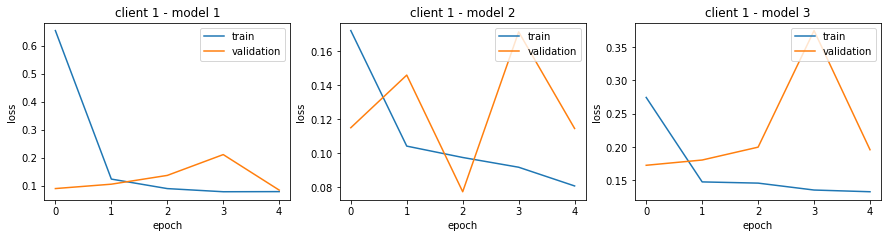

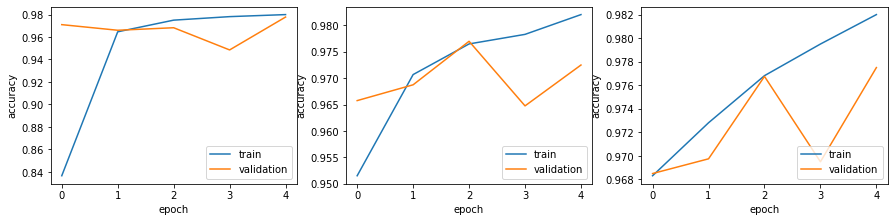

In [22]:
#Por último, grafico la historia de entrenamiento para cada uno de los modelos y cada uno de los clientes para entender que ha 
#pasado época a época

plt.figure(figsize=(15, 15))

for i in range(0,3):
    
    plt.subplot(4,3,i+1)
    plt.grid(False)
    plt.plot(history_client1[i].history['loss'])
    plt.plot(history_client1[i].history['val_loss'])
    plt.legend(['train', 'validation'], loc='upper right')
    plt.title('client 1 - model {}'.format(i+1))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
plt.show()

plt.figure(figsize=(15, 15))
for i in range(0,3):
    
    plt.subplot(4,3,i+1)
    plt.grid(False)
    plt.plot(history_client1[i].history['accuracy'])
    plt.plot(history_client1[i].history['val_accuracy'])
    plt.legend(['train', 'validation'], loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    
plt.show()

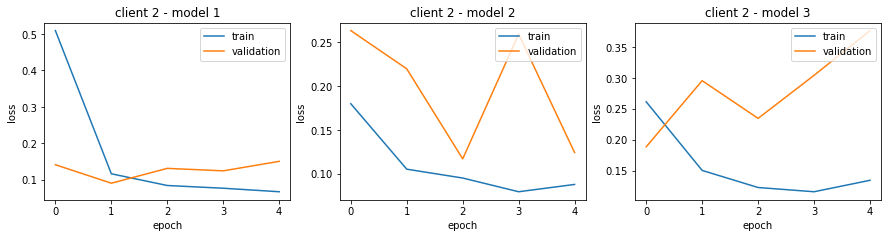

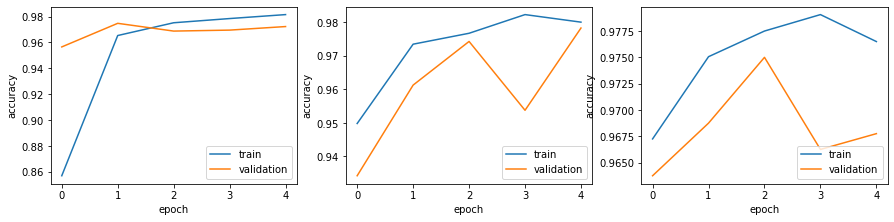

In [23]:
plt.figure(figsize=(15, 15))

for i in range(0,3):
    
    plt.subplot(4,3,i+1)
    plt.grid(False)
    plt.plot(history_client2[i].history['loss'])
    plt.plot(history_client2[i].history['val_loss'])
    plt.legend(['train', 'validation'], loc='upper right')
    plt.title('client 2 - model {}'.format(i+1))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
plt.show()

plt.figure(figsize=(15, 15))
for i in range(0,3):
    
    plt.subplot(4,3,i+1)
    plt.grid(False)
    plt.plot(history_client2[i].history['accuracy'])
    plt.plot(history_client2[i].history['val_accuracy'])
    plt.legend(['train', 'validation'], loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    
plt.show()

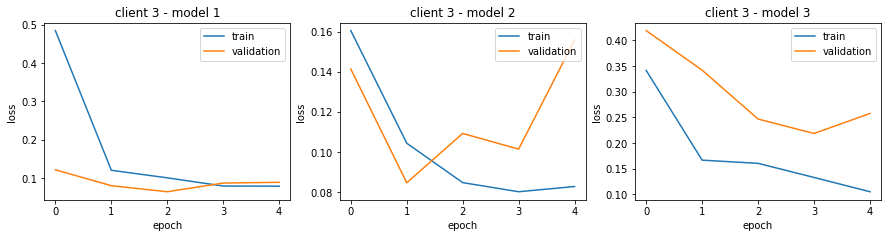

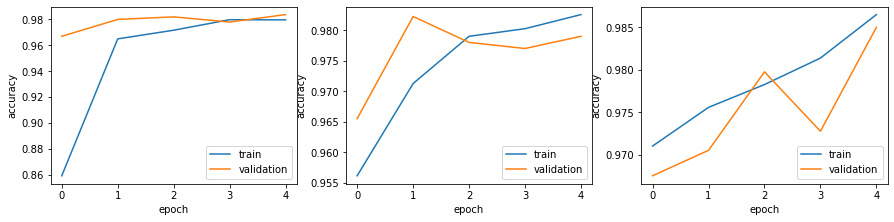

In [77]:
plt.figure(figsize=(15, 15))

for i in range(0,3):
    
    plt.subplot(4,3,i+1)
    plt.grid(False)
    plt.plot(history_client3[i].history['loss'])
    plt.plot(history_client3[i].history['val_loss'])
    plt.legend(['train', 'validation'], loc='upper right')
    plt.title('client 3 - model {}'.format(i+1))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
plt.show()

plt.figure(figsize=(15, 15))
for i in range(0,3):
    
    plt.subplot(4,3,i+1)
    plt.grid(False)
    plt.plot(history_client3[i].history['accuracy'])
    plt.plot(history_client3[i].history['val_accuracy'])
    plt.legend(['train', 'validation'], loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    
plt.show()

# Conclusiones

- El accuracy del modelo en el conjunto de test aumenta con cada iteración del proceso completo, es decir, el acuraccy 3> acuraccy 2> acuraccy 1.
- El modelo 1 no funciona bien, el resultado de la primera agregación, que es simplemente un promedio de los pesos entrenados de manera separada en cada uno de los clientes, no predice bien el conjunto de test.
-  En el caso de los modelos 2 y 3, éstos son inicializados con los pesos agregados del paso anterior. Es decir, en cada uno de los modelos se usan pesos que han sido entrenados en los demás. Podemos observar que esta vez ambos modelos funcionan bien ya que pueden predecir las imágenes con una accuracy > 0.97.
- Si observamos las gráficas del loss para los diferentes modelos, podemos ver que el loss en el conjunto de validacion es creciente miestras que en el conjunto de train es decreciente, esto quiere decir que siguieramos iterando durante más épocas habría over fitting, para evitar esto podemos agregar drop out de algunas neuronas en la capa densa o incluir un callback con early stoping.
- Si bien el loss aumenta con cada iteración del proceso ya que el proceso de agregación introduce ruido, el accuracy aumenta, esto es porque las capas de convolución se especializan en reconocer patrones que no son afectados por este ruido. 
